#  Lending Club Case Study : Risk analysis for loan applications 
[Lending Club](https://www.lendingclub.com/)

## Objective: To derive the key drivers behind customers defaulting

### Team Members :
    -  Aniket Singla
    -  Smita Behera


In [97]:
# Loading libraries to start with 
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
warnings.filterwarnings("ignore")

## `>> Data comprehension`

In [98]:
#Importing the data from csv file
data = pd.read_csv('./loan.csv')

#Taking a peak at the data
data.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [99]:
# Checking number of rows and columns 
print('Initial state of data : ',data.shape)


Initial state of data :  (39717, 111)


In [100]:
# Checking for columns with missing values
col_null =data.isnull().sum()
col_null[col_null.values > 0 ]

emp_title                      2459
emp_length                     1075
desc                          12940
title                            11
mths_since_last_delinq        25682
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 68, dtype: int64

### `Observations` 
####  `1.A number of columns do not have any data, these columns will be dropped`
####  `2.Dataset columns like Id, memberId , url etc are of no use for our analysis as we are not analysing at individual level.`
#### `3.Dataset has columns related to customer behaviour for instance, delinq_2yrs , earliest_cr_line which do not benefit our analysis to determine risk factors`



##  >> `Data Cleaning `


In [101]:
#Dropping columns with all values null as they will give no insights 
data.dropna(axis=1,how='all',inplace=True)

In [102]:
# Investigating further for more columns with missing values > 85% 
eightyfive_percent= round(data.shape[0]*.15)
col_null = data.isnull().sum()
col_null[col_null.values>eightyfive_percent]


desc                      12940
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

In [103]:
#Droping the above identified columns
data.drop(columns=list(col_null[col_null.values > eightyfive_percent].index), inplace=True)

In [104]:
# Removing Columns that have only a unique value
col_unique = data.nunique()
index_to_remove = col_unique[col_unique.values == 1].index
data.drop(columns=index_to_remove , inplace=True)

In [105]:
# Further removing columns like id, member_id and zipcode(not decoded)
del_cols = ["id","member_id","url","zip_code"]
data.drop(columns=del_cols, inplace=True)


In [106]:
#Removing Customer behavious columns , they are avaliable at the time of loan application , 
# thus they cannot be used to predict for default risk factors
      
customer_behaviour_columns=["delinq_2yrs","earliest_cr_line","inq_last_6mths","open_acc","total_acc","pub_rec",
                            "revol_bal","revol_util","out_prncp","out_prncp_inv","total_rec_prncp","total_rec_int",
                            "total_rec_late_fee","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","last_credit_pull_d",
                           "recoveries","total_pymnt_inv","total_pymnt"]

data.drop(columns=customer_behaviour_columns,inplace=True)
# checking dataset rows and columns
print("Current Shape of the data:",data.shape)

Current Shape of the data: (39717, 20)


In [107]:
#Looking at categorical data
data.describe(include='object')

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,addr_state
count,39717,39717,39717,39717,37258,38642,39717,39717,39717,39717,39717,39706,39717
unique,2,371,7,35,28820,11,5,3,55,3,14,19615,50
top,36 months,10.99%,B,B3,US Army,10+ years,RENT,Not Verified,Dec-11,Fully Paid,debt_consolidation,Debt Consolidation,CA
freq,29096,956,12020,2917,134,8879,18899,16921,2260,32950,18641,2184,7099


In [108]:
#emp_title has 28027 values and will be of little help
data.drop(columns=['emp_title','title'], inplace=True)

In [109]:
#Extract numeric values for the data
#data['emp_length']=(data.emp_length.str.extract('([0-9]+)'))


# >>` Preparing Data for EDA (transformation)`

In [110]:
data.describe(include='all')


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717,39717,39717.000000,39717,39717,38642,39717,3.971700e+04,39717,39717,39717,39717,39717,39717.000000,39020.000000
unique,NaN,NaN,NaN,2,371,NaN,7,35,11,5,NaN,3,55,3,14,50,NaN,NaN
top,NaN,NaN,NaN,36 months,10.99%,NaN,B,B3,10+ years,RENT,NaN,Not Verified,Dec-11,Fully Paid,debt_consolidation,CA,NaN,NaN
freq,NaN,NaN,NaN,29096,956,NaN,12020,2917,8879,18899,NaN,16921,2260,32950,18641,7099,NaN,NaN
mean,11219.443815,10947.713196,10397.448868,NaN,NaN,324.561922,NaN,NaN,NaN,NaN,6.896893e+04,NaN,NaN,NaN,NaN,NaN,13.315130,0.043260
std,7456.670694,7187.238670,7128.450439,NaN,NaN,208.874874,NaN,NaN,NaN,NaN,6.379377e+04,NaN,NaN,NaN,NaN,NaN,6.678594,0.204324
min,500.000000,500.000000,0.000000,NaN,NaN,15.690000,NaN,NaN,NaN,NaN,4.000000e+03,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,NaN,NaN,167.020000,NaN,NaN,NaN,NaN,4.040400e+04,NaN,NaN,NaN,NaN,NaN,8.170000,0.000000
50%,10000.000000,9600.000000,8975.000000,NaN,NaN,280.220000,NaN,NaN,NaN,NaN,5.900000e+04,NaN,NaN,NaN,NaN,NaN,13.400000,0.000000
75%,15000.000000,15000.000000,14400.000000,NaN,NaN,430.780000,NaN,NaN,NaN,NaN,8.230000e+04,NaN,NaN,NaN,NaN,NaN,18.600000,0.000000


## Insights from above table
1. Distibution of loan_amnt, funded_amnt, funded_amnt_inv is almost same, so we can use any one.
2. Maximum folks are in 36 minths term rate.
3. There are 7 grades with B has grade assigned to most customer and subgrade B3.
4. Employment length of most customers is above 10+.
5. Home ownership for most customers is "RENT".
6. Annual income has outliers to deal with making it very skewed.
7. Majority of the customers are "non veriifed".
8. Highest number of the loans are issued in December month of year 2011.
9. Maximum loan reason is for "debt consolidation"
10. Highest number of loans are in region "CA".
11. pub_rec_bankcruptcies can be converted to categorical or discrete data.

In [111]:
#We can see term has two set of value
data['term'].value_counts()


 36 months    29096
 60 months    10621
Name: term, dtype: int64

In [112]:
data['term'] = data['term'].astype("category")

In [113]:
data['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
Name: int_rate, dtype: object

In [114]:
#removing % sign and converting object -> float type
data['int_rate']=data['int_rate'].apply(lambda x: float(x.split("%")[0]))


In [115]:
data['int_rate'].describe()


count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

In [116]:
# Splitting issue date into year and month
data.issue_d = pd.to_datetime(data['issue_d'], format='%b-%y')
data['year']=data['issue_d'].dt.year
data['month']=data['issue_d'].dt.month

data['year'],data['month']

(0        2011
 1        2011
 2        2011
 3        2011
 4        2011
          ... 
 39712    2007
 39713    2007
 39714    2007
 39715    2007
 39716    2007
 Name: year, Length: 39717, dtype: int64,
 0        12
 1        12
 2        12
 3        12
 4        12
          ..
 39712     7
 39713     7
 39714     7
 39715     7
 39716     6
 Name: month, Length: 39717, dtype: int64)

In [117]:
data['loan_status'].value_counts()
#data has some current loan_status rows , it does not give insights to help in accepting or rejecting , so we should drop these rows

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [118]:
## Removing values with loan_status as "Current"
data = data[~( data['loan_status'] == 'Current')]
data.shape

(38577, 20)

In [119]:
# Filling up null values of employment length
data['emp_length']=data['emp_length'].fillna(0)

# Exploratory Data Analysis (EDA)

In [120]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,pub_rec_bankruptcies,year,month
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0.0,2011,12
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,GA,1.00,0.0,2011,12
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0.0,2011,12
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,CA,20.00,0.0,2011,12
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,AZ,11.20,0.0,2011,12


### From the analysis so far, we can categorize the columns as following:

- Numerical Continuous -loan_amnt, funded_amnt, funded_amnt_inv, installment, int_rate,annual_inc, loan_amnt, dti
- Numerical Discrete - pub_rec_bankruptcies 
- Categorical Nominal - addr_state, purpose, loan_status, verification_status, home_ownership, term
- Categorical Ordinal - issue_d.year,issue_d.month, emp_length, grade,sub_grade


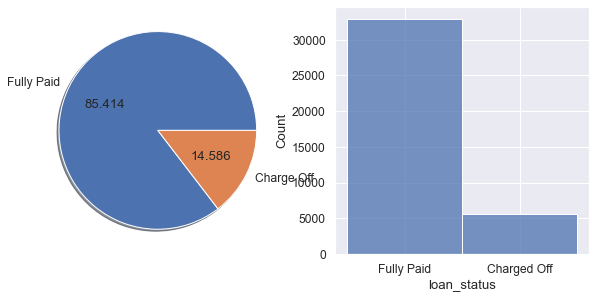

In [121]:
# Target is loan_status
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.pie(data['loan_status'].value_counts(), labels=['Fully Paid','Charge Off'], shadow=True,autopct='%.3f')
plt.subplot(2,2,2)
sns.histplot(x='loan_status', data=data, edgecolor='white')
plt.show()

## Observations
1. 85.5 percent loans were fully paid.
2. Close to 14.5% loans were charged off

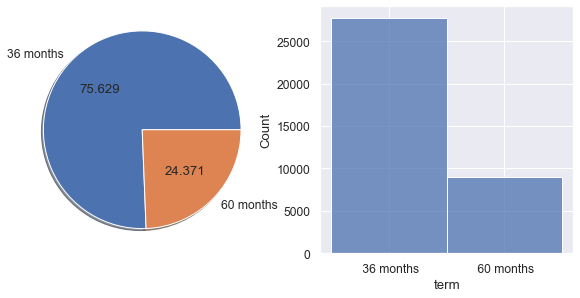

In [141]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.pie(data['term'].value_counts(), labels=['36 months','60 months'], shadow=True,autopct='%.3f')
plt.subplot(2,2,2)
sns.histplot(x='term', data=data, edgecolor='white')
plt.show()

## Observation
1. 75 percent of loans were for 36 month term
2. 25 percent of loans were for 60 month term

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   loan_amnt             38577 non-null  int64         
 1   funded_amnt           38577 non-null  int64         
 2   funded_amnt_inv       38577 non-null  float64       
 3   term                  38577 non-null  category      
 4   int_rate              38577 non-null  float64       
 5   installment           38577 non-null  float64       
 6   grade                 38577 non-null  object        
 7   sub_grade             38577 non-null  object        
 8   emp_length            38577 non-null  object        
 9   home_ownership        38577 non-null  object        
 10  annual_inc            38577 non-null  float64       
 11  verification_status   38577 non-null  object        
 12  issue_d               38577 non-null  datetime64[ns]
 13  loan_status     

In [123]:
##Only two columns have not null values
data['emp_length']=data.emp_length.fillna(0)
data['pub_rec_bankruptcies']=data.pub_rec_bankruptcies.fillna(0)

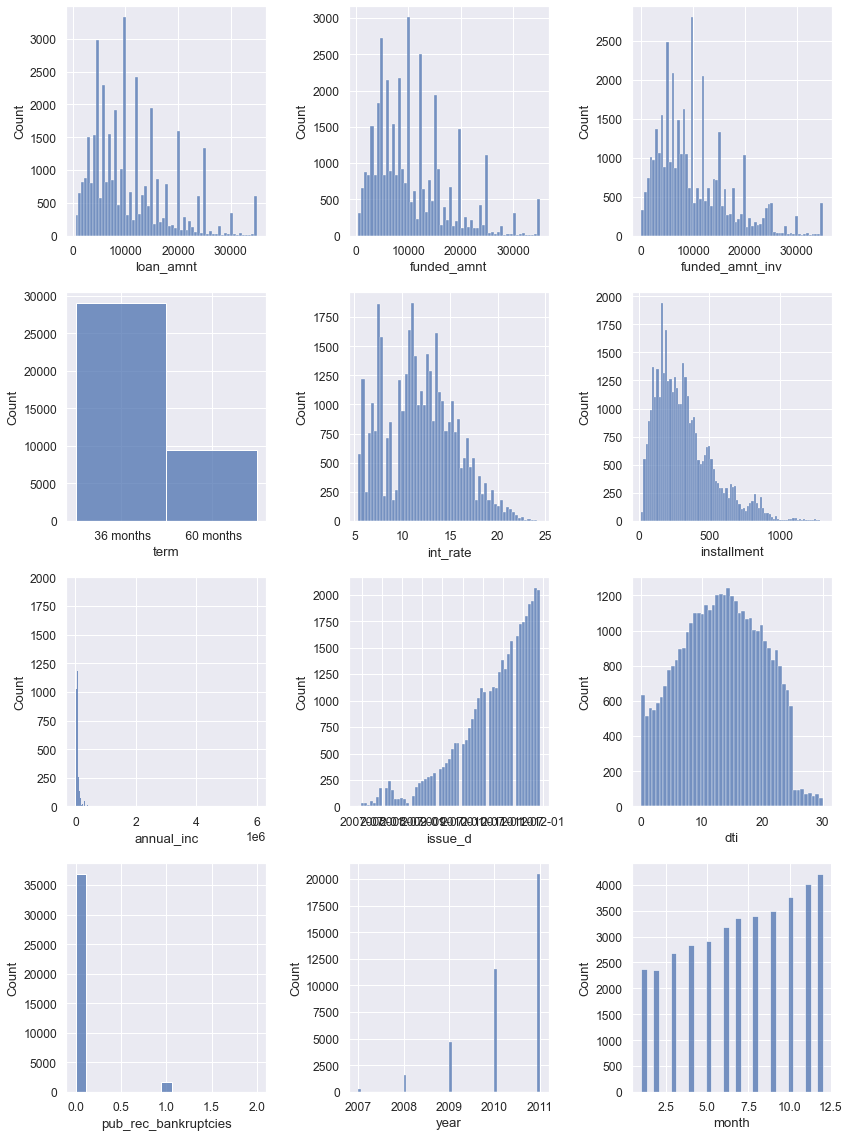

In [124]:
## Plotting histogram for all numeric values
cols,rows = 3,4
num_cols = data.select_dtypes(exclude='object').columns
fig = plt.figure( figsize=(cols*4, rows*4))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    bin=sns.histplot(x = data[col], ax = ax,edgecolor='white')

fig.tight_layout()  
plt.show()


## From above hisrogram, following are the observations:
1. Most customers take loan amount around 5000 and 10000, a tendency to round off
2. Maximum customers ahve interest rate between 10 to 12.5 %
3. Most customers have installment of around 200 which can be further binned for analysis
4. Annual income has very large outliers 


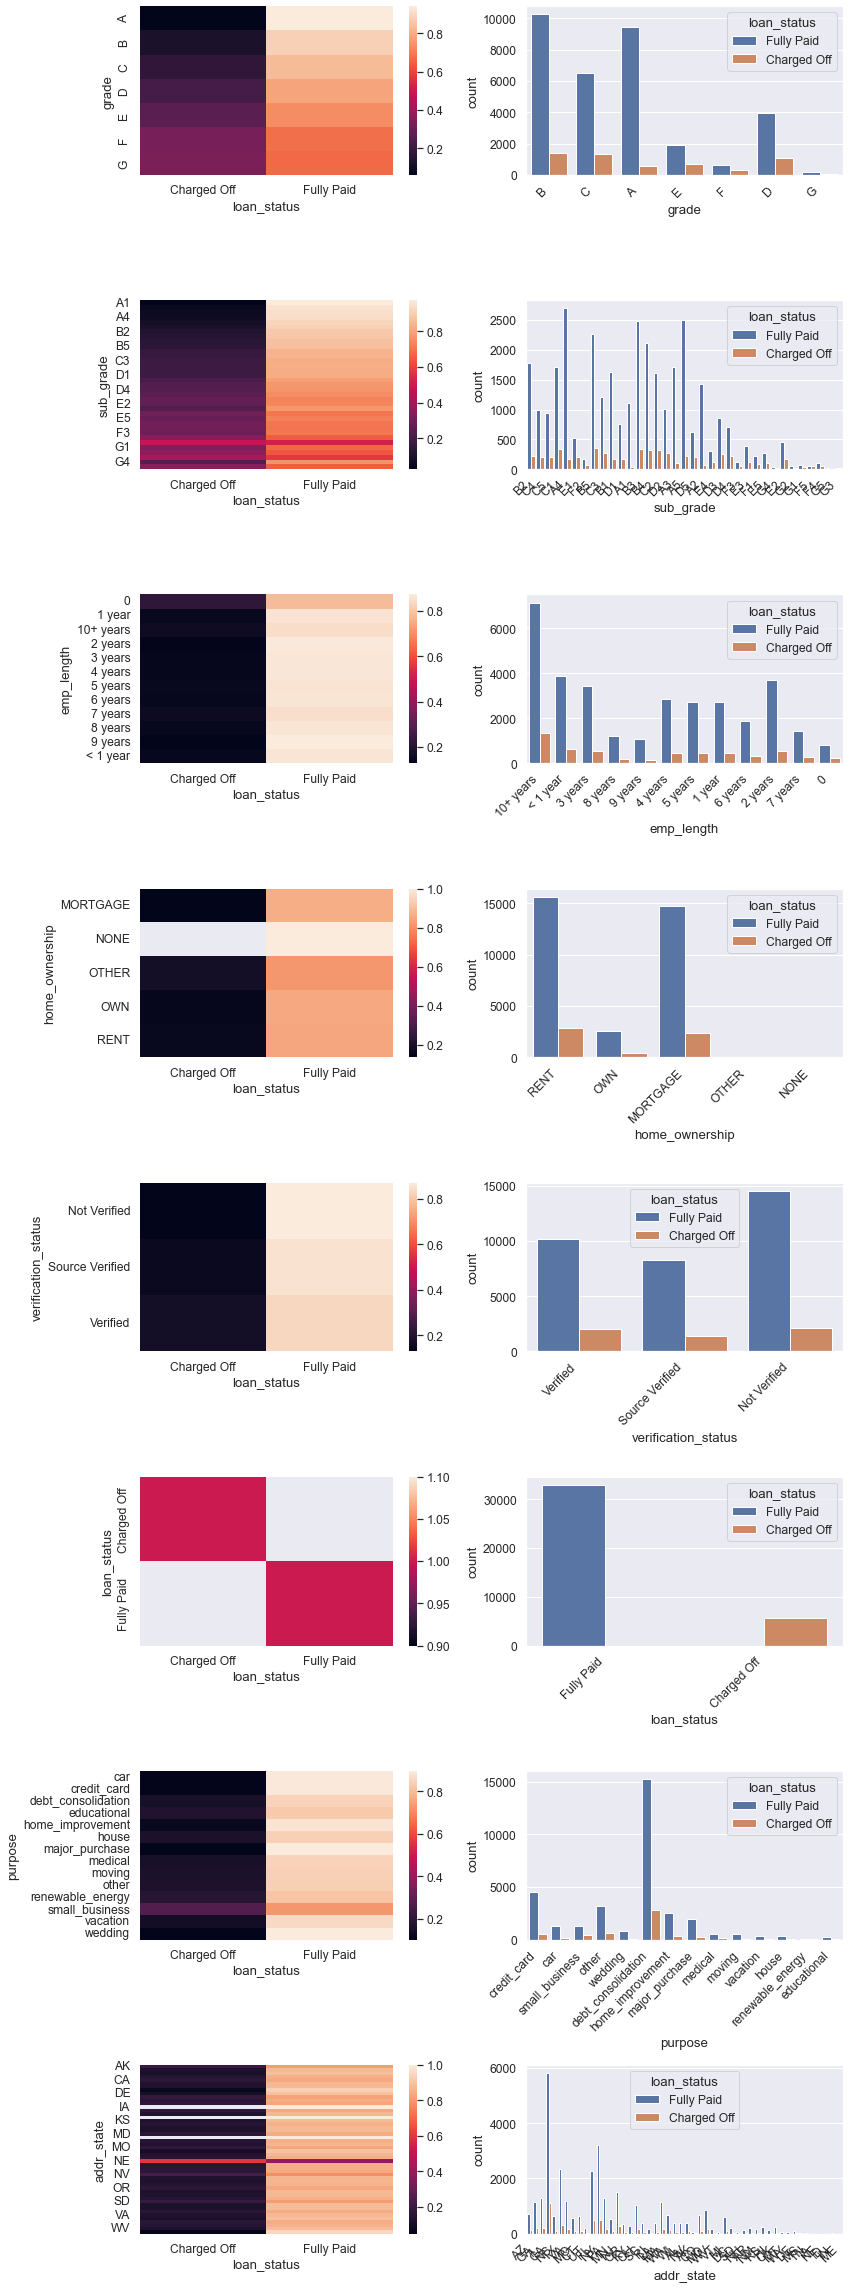

In [125]:
#Plotting Categorical Columns 
cols, rows = 2,8
fig = plt.figure(figsize= (cols*6,rows*4))
all_cats = data.select_dtypes(include='object')
for i, col in enumerate(all_cats):
    a=data.groupby([col,'loan_status'])['loan_status'].count()
    b=data.groupby([col]).loan_status.count()
    ax=fig.add_subplot(rows,cols,(i+1)*2-1)
    a=a/b
    sns.heatmap(a.unstack())    
    ax=fig.add_subplot(rows, cols, (i+1)*2)
    sns.countplot(x=data[col], ax=ax,hue=data['loan_status'])
    plt.xticks(rotation=45, ha='right')
   
fig.tight_layout()  
plt.show()

## Observations from above map of Heatmap for % of "Charge off" and "Fully Paid" for each category against countplots

1. For different grades, we can draw a positive conclusion that defaulters are lowest in grade A inspite of a good number of loans. Charge offs are highest in B, C and D,but looking at percentage, we can conclude that likelihood of Charge offs is highest in grade G and F though the numbers of loans in this category are less.
2. For sub-Grade, Chargoff are highest in B3, but based on percentages, we can conclude charge off are highest for sub grade G1 and G3 even if the number of loans are least.
3. Though charge offs are highest for 10+ years but percentages indicate not very hig impact of emp_length on charge offs though 10+ years are still on high number of defaulters.
4. home_ownership shows highest charge offs for Mortgage and rent but percentage of chargeoff for each category is more or less same with category "OTHER" having a slighly more risky group.
5. Highest number of chargeoff are for "Not-verified" but the percentage is highest for "verified" indicating a major flaw in verirification process.
6. When purpose of loan is "small_business", the defaulters are highest, followed by renewable_energy,educational and others.
7. Highest percentage of charge offs are for 'WY'

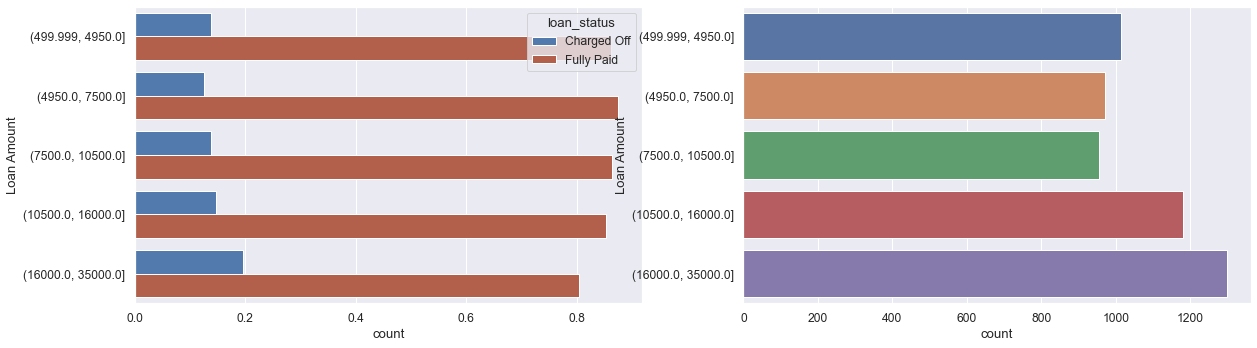

In [149]:
##Plotting Loan amount for different quartiles
data['loan_amount_groups'] = pd.qcut(data['loan_amnt'],q=5)

## deriving percentage for each bin
loan_amt_group=data.groupby(['loan_amount_groups','loan_status'])['loan_status'].count()
loan_amt_count=data.groupby(['loan_amount_groups']).loan_status.count()
loan_amt_group=loan_amt_group/loan_amt_count
loan_amt_group=loan_amt_group.reset_index(name = 'count')
fig, ax = plt.subplots(figsize = (20,12))
plt.subplot(2,2,1)
sns.barplot(data =loan_amt_group,y='loan_amount_groups', x='count', hue ='loan_status',palette=sns.diverging_palette(250, 20, n=2)) 
plt.ylabel('Loan Amount')
plt.subplot(2,2,2)
sns.countplot(y='loan_amount_groups', data=data[data.loan_status == 'Charged Off'])
plt.ylabel('Loan Amount')
plt.show()



## Observation
- Charge off is almost linearly increasing with increase in loan amount

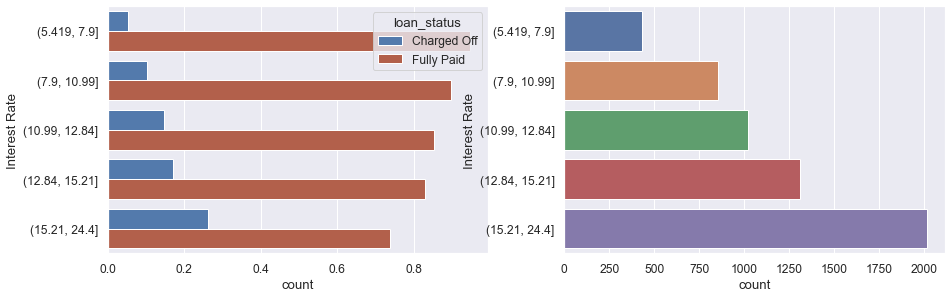

In [127]:
##Plotting interest rate for different quartile
data['int_rate_groups'] = pd.qcut(data['int_rate'],q=5)

## deriving percentage for each bin
int_rate_group=data.groupby(['int_rate_groups','loan_status'])['loan_status'].count()
int_rate_count=data.groupby(['int_rate_groups']).loan_status.count()
int_rate_group=int_rate_group/int_rate_count
int_rate_group=int_rate_group.reset_index(name = 'count')
fig, ax = plt.subplots(figsize = (15,10))
plt.subplot(2,2,1)
sns.barplot(data =int_rate_group,y='int_rate_groups', x='count', hue ='loan_status',palette=sns.diverging_palette(250, 20, n=2)) 
plt.ylabel('Interest Rate')
plt.subplot(2,2,2)
sns.countplot(y='int_rate_groups', data=data[data.loan_status == 'Charged Off'])
plt.ylabel('Interest Rate')
plt.show()

## Observation

- Charge offs increase almost linearly with increase in interest rate with Highest defaulters in range 15% to 24 % 

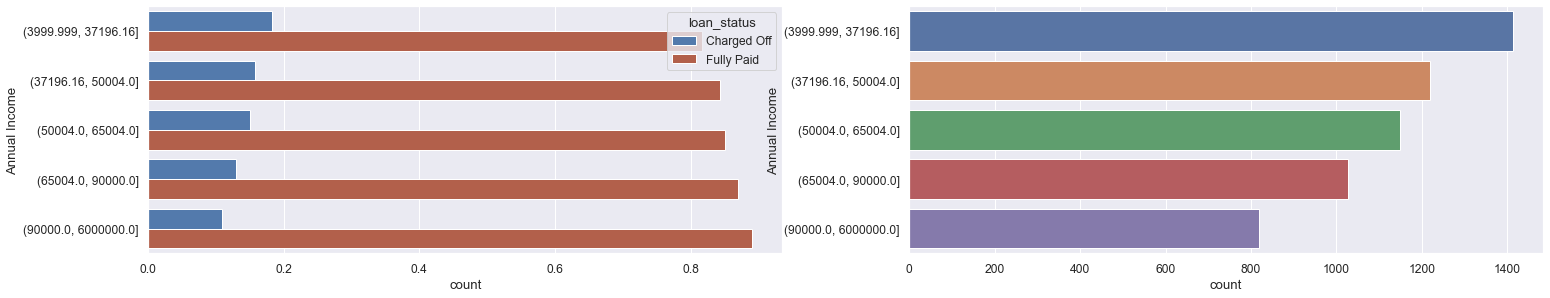

In [128]:
##Plotting annual income for different quartile
data['annual_inc_group'] = pd.qcut(data['annual_inc'],q=5)

## deriving percentage for each bin
annual_inc_group=data.groupby(['annual_inc_group','loan_status'])['loan_status'].count()
annual_inc_group_count=data.groupby(['annual_inc_group']).loan_status.count()
annual_inc_group=annual_inc_group/annual_inc_group_count
annual_inc_group=annual_inc_group.reset_index(name = 'count')
fig, ax = plt.subplots(figsize = (25,10))
plt.subplot(2,2,1)
sns.barplot(data =annual_inc_group,y='annual_inc_group', x='count', hue ='loan_status',palette=sns.diverging_palette(250, 20, n=2)) 
plt.ylabel('Annual Income')
plt.subplot(2,2,2)
sns.countplot(y='annual_inc_group', data=data[data.loan_status == 'Charged Off'])
plt.ylabel('Annual Income')
plt.show()

## Observation
- Charge offs is less for higher income groups and increase for lower income groups

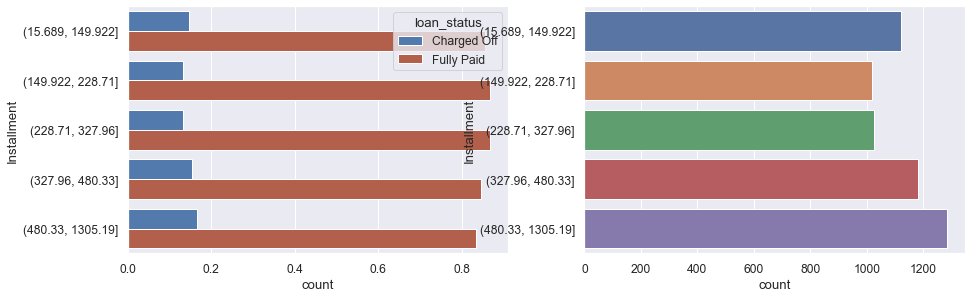

In [129]:
##Plotting installment for different quartile
data['installment_group'] = pd.qcut(data['installment'],q=5)

## deriving percentage for each bin
installment_group=data.groupby(['installment_group','loan_status'])['loan_status'].count()
installment_group_count=data.groupby(['installment_group']).loan_status.count()
installment_group=installment_group/installment_group_count
installment_group=installment_group.reset_index(name = 'count')
fig, ax = plt.subplots(figsize = (15,10))
plt.subplot(2,2,1)
sns.barplot(data =installment_group,y='installment_group', x='count', hue ='loan_status',palette=sns.diverging_palette(250, 20, n=2)) 
plt.ylabel('Installment')
plt.subplot(2,2,2)
sns.countplot(y='installment_group', data=data[data.loan_status == 'Charged Off'])
plt.ylabel('Installment')
plt.show()

## Observation
- There seems to be no relationship between installment and charge offs

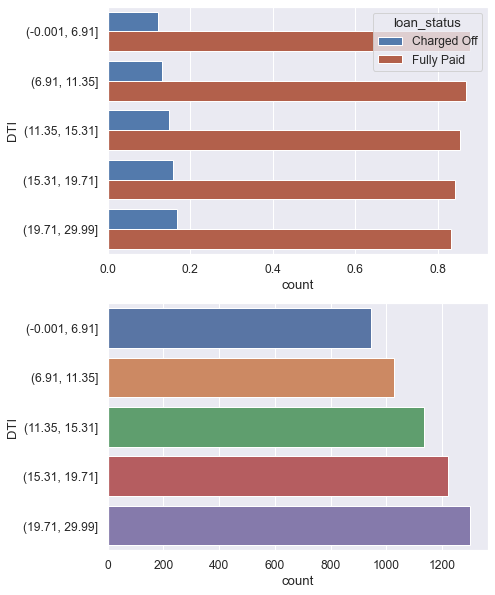

In [130]:
##Plotting dti for different quartile
data['dti_group'] = pd.qcut(data['dti'],q=5)

## deriving percentage for each bin
dti_group=data.groupby(['dti_group','loan_status'])['loan_status'].count()
dti_group_count=data.groupby(['dti_group']).loan_status.count()
dti_group=dti_group/dti_group_count
dti_group=dti_group.reset_index(name = 'count')
fig, ax = plt.subplots(figsize = (15,10))
plt.subplot(2,2,1)
sns.barplot(data =dti_group,y='dti_group', x='count', hue ='loan_status',palette=sns.diverging_palette(250, 20, n=2)) 
plt.ylabel('DTI')
plt.subplot(2,2,3)
sns.countplot(y='dti_group', data=data[data.loan_status == 'Charged Off'])
plt.ylabel('DTI')
plt.show()

## Observations from above diagrams:
- chargeoff increase gradually with DTI

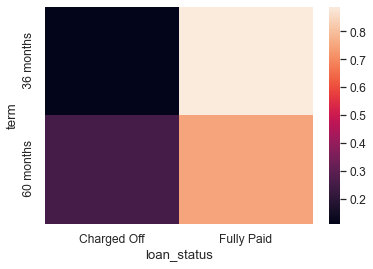

In [131]:
##Plotting term for loan status

## deriving percentage for each bin
term_group=data.groupby(['term','loan_status'])['loan_status'].count()
term_group_count=data.groupby(['term']).loan_status.count()
term_group=term_group/term_group_count
term_group=term_group.unstack()
##plotting
sns.heatmap(term_group)    

plt.show()

## Observation
- Charge offs are high for 60 months term  but from previous graphs we also, know that 36 months terms is the choice for most lenders

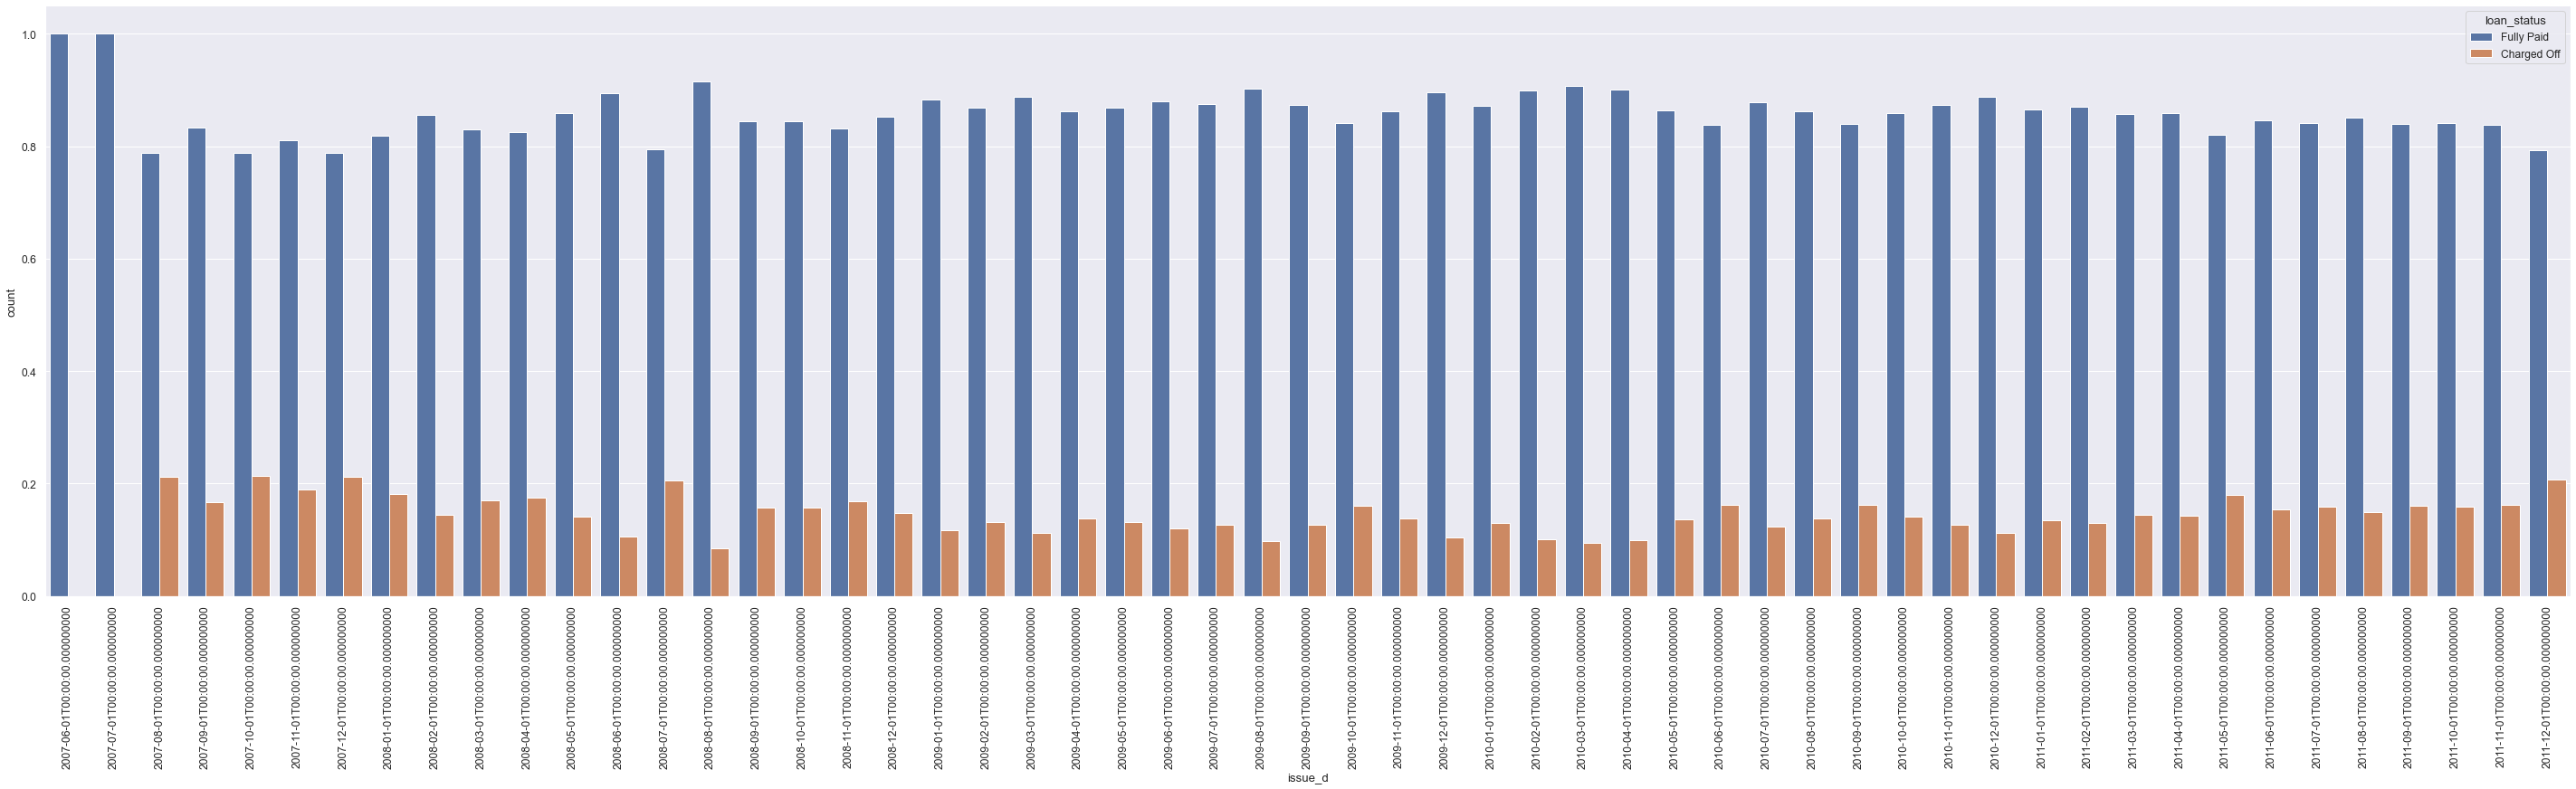

In [132]:
# Plotting term for loan status

# deriving percentage for each bin
plt.figure(figsize=(50, 12))
issue_group_d=data.groupby(['issue_d','loan_status'])['loan_status'].count()
issue_group_d_cnt=data.groupby(['issue_d']).loan_status.count()
issue_group_d=(issue_group_d/issue_group_d_cnt)
issue_group_d=issue_group_d.reset_index(name='count')

# sns.barplot(issue_group_d)  
sns.barplot(data =issue_group_d,x='issue_d', y='count', hue ='loan_status',palette="deep")
plt.xticks(rotation=90)
plt.show()
# issue_group_d

## Observation
There is not much co-relation between year and month of issue of loan with charge off but at the same time it is to be noted that highest number of loans were take year December, 2011.

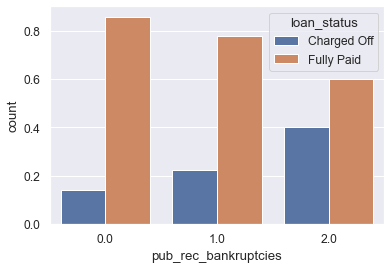

In [133]:
##Plotting term for loan status

## deriving percentage for each bin
pub_rec_bankruptcies_d=data.groupby(['pub_rec_bankruptcies','loan_status'])['loan_status'].count()
pub_rec_bankruptcies_d_cnt=data.groupby(['pub_rec_bankruptcies']).loan_status.count()
pub_rec_bankruptcies_d=(pub_rec_bankruptcies_d/pub_rec_bankruptcies_d_cnt)
pub_rec_bankruptcies_d=pub_rec_bankruptcies_d.reset_index(name='count')
pub_rec_bankruptcies_d
#sns.barplot(issue_group_d)  
sns.barplot(data =pub_rec_bankruptcies_d,x='pub_rec_bankruptcies', y='count', hue ='loan_status',palette="deep")

plt.show()
#issue_group_d

## Observations
- More bankcruptcy indicates higher risk

### `Observations`
####   `-  Most of the loans taken for debt consolidation(47%) and Credit card bill payment`
####  ` -  Other is also one of the main area where loans were taken.`
####   `-  Defaulters are higher when purpose of loan is  debt considation`

####  ` - average loan intrest rate is 12%`
####  `- after 75% percentile interest rate increased rapidly from 14% to 25% incicating presence of outliers`

## Correlation Matrix - Quantitative Variables :

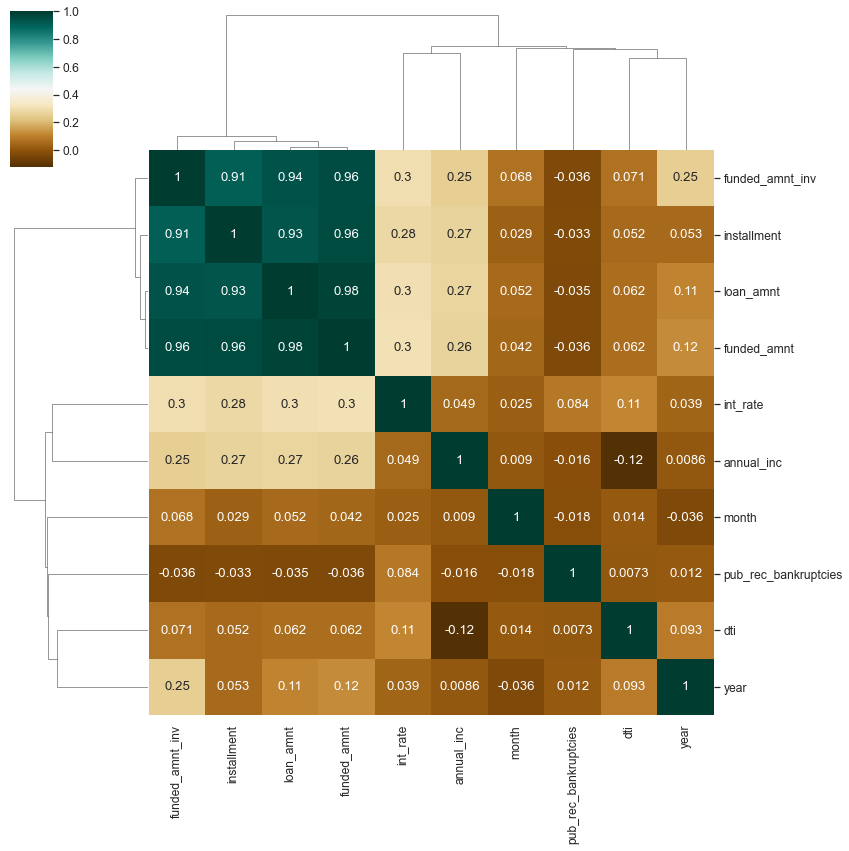

In [134]:
loan_correlation = data.corr()
sns.set(font_scale=1.1)
sns.clustermap(loan_correlation,annot=True,figsize=(12, 12),cmap="BrBG")
plt.show()

### `Observations`
####   `- Loan Installments , Amount, Investor amount, Funding amount are strongly correlated `
####   `- Dti (Debt-to-income ratio) and Annual income are negativly correlated, with low annual income having high Dti`
####   `- Annual income and employment years show positive correlation`
####  ` - Loan Interest rate and Annual income show negative correlation`


## Multivariate Analysis

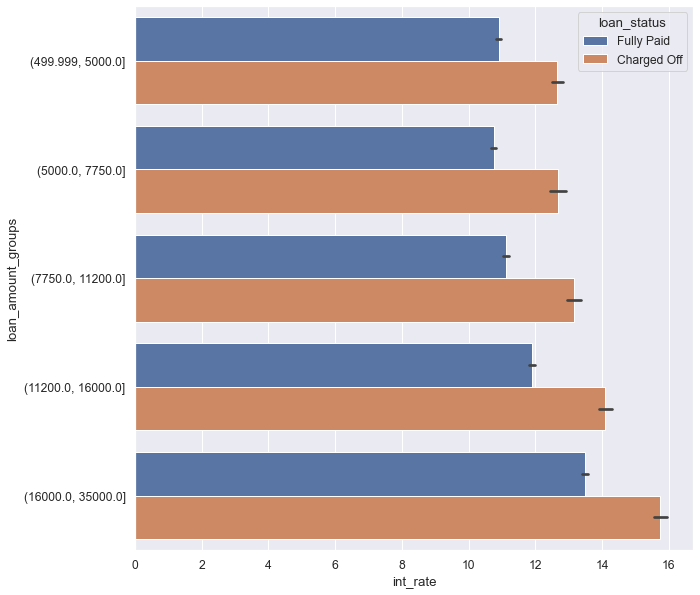

In [135]:
plt.figure(figsize=(10,10))
sns.barplot(data =data,y='loan_amount_groups', x='int_rate', hue ='loan_status',palette="deep")
plt.show()

## Observation
- Higher interest rate and high loan amount is most risky and prone to defaulting

In [136]:
data['loan_amount_groups']

0        (499.999, 5000.0]
1        (499.999, 5000.0]
2        (499.999, 5000.0]
3        (7750.0, 11200.0]
5        (499.999, 5000.0]
               ...        
39712    (499.999, 5000.0]
39713    (7750.0, 11200.0]
39714    (499.999, 5000.0]
39715    (499.999, 5000.0]
39716     (5000.0, 7750.0]
Name: loan_amount_groups, Length: 38577, dtype: category
Categories (5, interval[float64, right]): [(499.999, 5000.0] < (5000.0, 7750.0] < (7750.0, 11200.0] < (11200.0, 16000.0] < (16000.0, 35000.0]]

<Figure size 1440x1080 with 0 Axes>

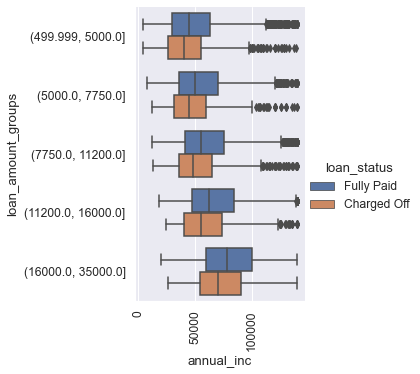

In [137]:
# fig,ax = plt.subplots(figsize = (15,6))
data = data[data.annual_inc <= data['annual_inc'].quantile(0.95)]

plt.figure(figsize=(20,15))
sns.catplot(data =data,y ='loan_amount_groups', x ='annual_inc', hue ='loan_status',palette="deep",kind = 'box')
plt.xticks(rotation=90)
plt.show()

## Observation
- income groups and loan amount are portively influence each other
- However, the charge offs for lower incomegroup with lower loan amount is less( looking at the upper quantile)

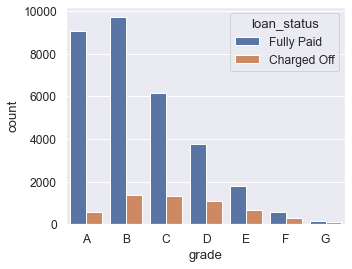

In [145]:
plt.figure(figsize=(5, 4))
data_sort=data.sort_values(by='grade')

sns.countplot(x ='grade', hue = "loan_status", data = data_sort )
plt.show()


## Observations
1. Grade B has highest number of both fully paid and charged off loans
2. Need Further analysis for groups E , F and G

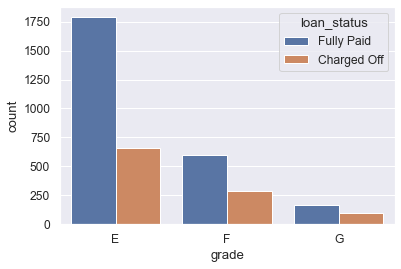

In [146]:
data_sort=data.sort_values(by='grade')

data_sort_grade = data_sort[(data_sort['grade'] == 'E') | (data_sort['grade']  == 'F') | (data_sort['grade']  == 'G') ]
sns.countplot(x ='grade', hue = "loan_status", data = data_sort_grade )
plt.show()

## Observations
1. Group G , F and E has the highest percentage of defaulted loans

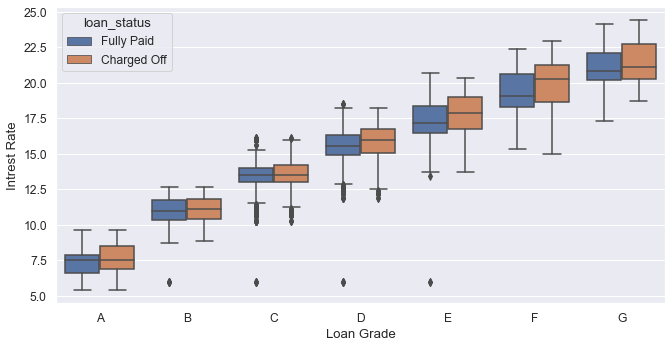

In [147]:
plt.figure(figsize=(24, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'grade', y = 'int_rate',hue='loan_status', data = data_sort)
plt.xlabel('Loan Grade')
plt.ylabel('Intrest Rate')
plt.show()

## Observations
1. Lower Grades of Loans have higher interst rate 

<Figure size 1440x1440 with 0 Axes>

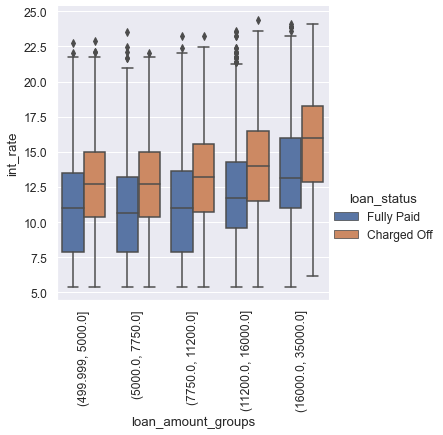

In [142]:
plt.figure(figsize=(20,20))
sns.catplot(data =data,y ='int_rate', x ='loan_amount_groups', hue ='loan_status',palette="deep",kind = 'box')
plt.xticks(rotation=90)
plt.show()

## Observation
- The median for charged off loans is higher for each group, indicating the interest rate in generalfor charged off loans is pretty high compared to that of fully paid loans in all the loan_amount groups.

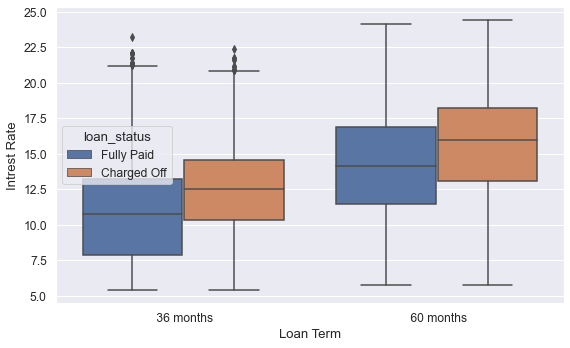

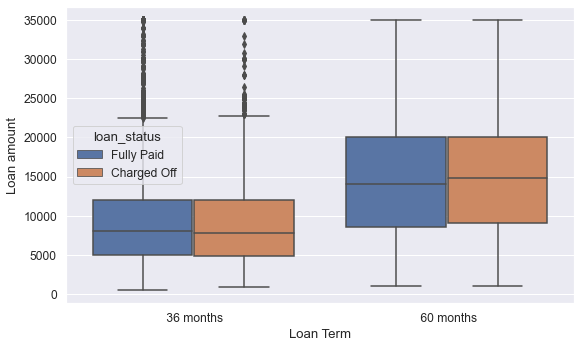

In [144]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'term', y = 'int_rate',hue='loan_status', data = data)
plt.xlabel('Loan Term')
plt.ylabel('Intrest Rate')
plt.show()

plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'term', y = 'loan_amnt',hue='loan_status', data = data)
plt.xlabel('Loan Term')
plt.ylabel('Loan amount')
plt.show()

## Observations
1. Intrest rate is higher for most loans with 60 month term


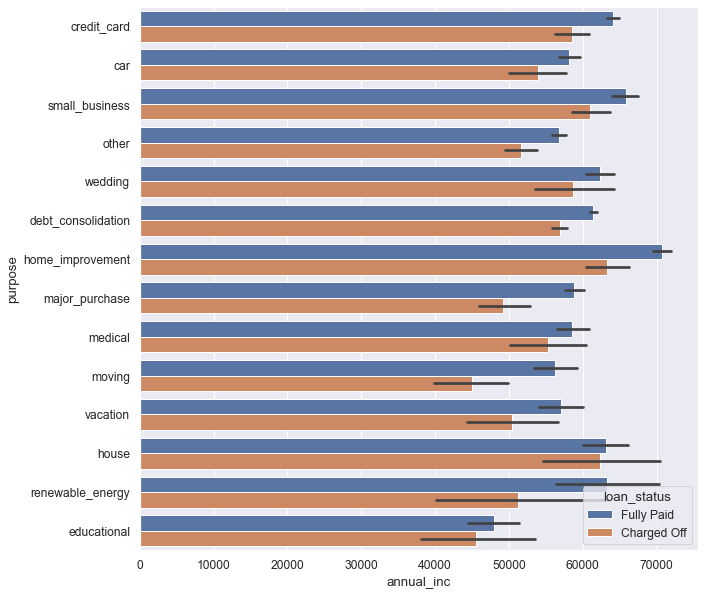

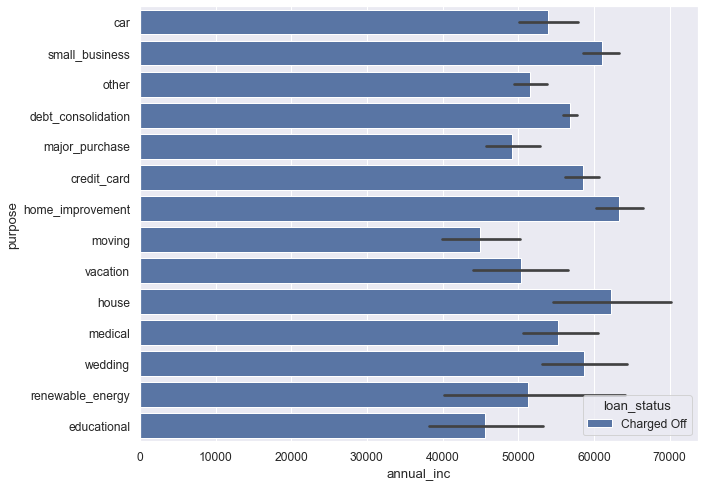

In [150]:
plt.figure(figsize=(10,10))
abc=sns.barplot(data =data,x='annual_inc', y='purpose', hue ='loan_status',palette="deep")
plt.show()
plt.figure(figsize=(10,8))
chargedoff = data[data.loan_status == 'Charged Off']
abc=sns.barplot(data =chargedoff,x='annual_inc', y='purpose', hue ='loan_status',palette="deep")

Analyzing Further for more clear details

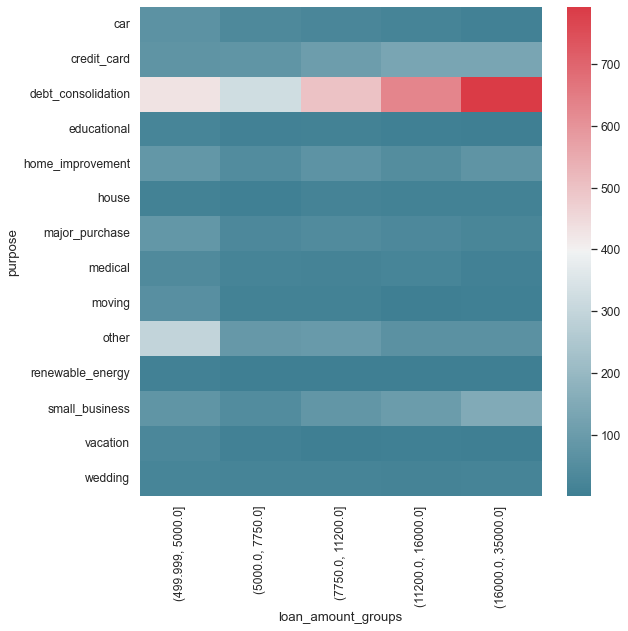

In [140]:
# Analyzing impact of purpose on loan status
data_chargeoff=data[data['loan_status']=='Charged Off']
g=data_chargeoff.groupby(['purpose','loan_amount_groups']).loan_amount_groups.count().unstack()
plt.figure(figsize=(9,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(g,cmap=cmap)
plt.show()

## Observation
- Charge offs are highest for higher loan amount groups when purpose is "debt consolidation"